# Classification of Intel image dataset with ResNet50
Intel image dataset consist of images of Natural Scenes around the world. The data contains around 25k images of size 150x150 distributed under 6 categories: buildings, forest, glacier, mountain, sea, street.
The ResNet architecture is considered to be among the most popular Convolutional Neural Network architectures around. Introduced by Microsoft Research in 2015, Residual Networks (ResNet in short) broke several records when it was first introduced in this paper [here](https://arxiv.org/pdf/1512.03385.pdf). Deep neural networks perform better than shallower neural networks. As the depth of the neural network increases, the model becomes more eligible to learn more complex patterns of training data. Some of the benefits of using the ResNet model include:

1. Improved accuracy: ResNet models are able to achieve very high accuracy on image classification tasks, surpassing previous state-of-the-art models.

2. Improved training: ResNet models use skip connections that allow the gradient to flow more easily during training, which helps to avoid the vanishing gradient problem and allows for deeper network architectures.

3. Better generalization: ResNet models are less prone to overfitting, meaning they can generalize well to new data, making them useful for a variety of computer vision tasks.

4. Flexibility: ResNet models can be fine-tuned on a variety of image recognition tasks, including object detection and segmentation.

5. Speed: ResNet models can be trained efficiently on modern GPUs, allowing for faster training times compared to other deep learning models.

##### In this notebook ResNet50 architecture is used for classification of images.


## Table of Content

- [1 - Packages](#1)
- [2 - Generating image datasets and labels](#2)
- [3 - Creating ResNet50 model](#3)
    - [3.1 - The Identity Block](#3-1)
    - [3.2 - The Convolutional Block](#3-2)
    - [3.3 - The ResNet50 model](#3-3)
- [4 - Training the model](#4)
- [5 - Making Predictions](#5)
- [6 - Analysing results](#6)

<a name='1'></a>
## 1 - Packages

In [22]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from image_data_generator import image_data_generator_train, image_data_generator_valid, image_data_generator_test

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.layers import Dense, Conv2D, MaxPool2D, Activation, Flatten, Dropout, Input, ZeroPadding2D, Add, BatchNormalization, AveragePooling2D
from keras.initializers import random_uniform, glorot_uniform

<a name='2'></a>
## 2 - Generating image datasets and labels

In [23]:
# Preprocessing and augmenting datasets
train_generator = image_data_generator_train('Data/Train')
valid_generator = image_data_generator_valid('Data/Valid')
test_generator = image_data_generator_test('Data/Test')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7300 images belonging to 1 classes.


<a name='3'></a>
## 3 - Creating The Model

<a name='3-1'></a>
### 3.1 - The Identity block

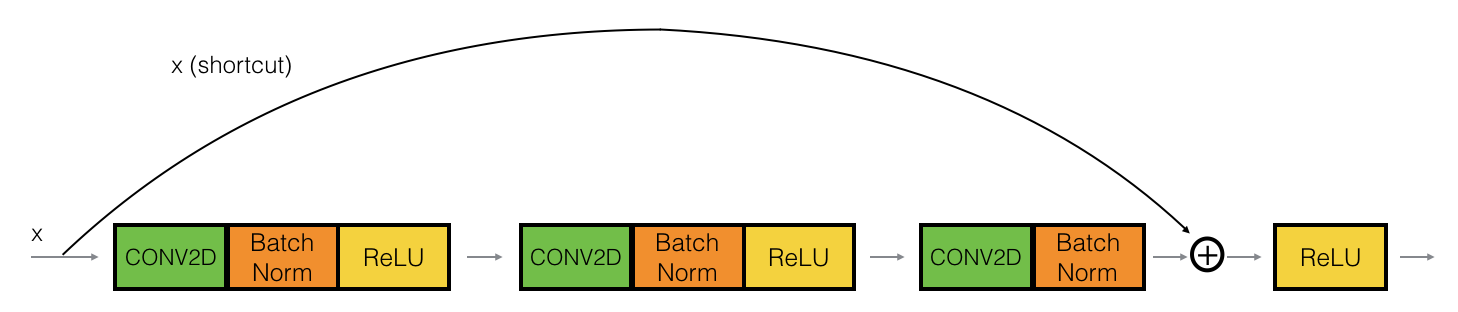

In [24]:
# Creating the Identity block

def identity_block(X, filters, initializer=random_uniform):
    F1, F2, F3 = filters
    
    X_shortcut = X

    # First component of the main path
    X = Conv2D(F1, (1, 1), padding='valid', strides=1, kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of the main path
    X = Conv2D(F2, (3, 3), padding='same', strides=1, kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of the main path
    X = Conv2D(F3, (1, 1), padding='valid', strides=1, kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)

    # Adding up main and shortcut values
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

<a name='3-2'></a>
### 3.2 - The Convolutional block

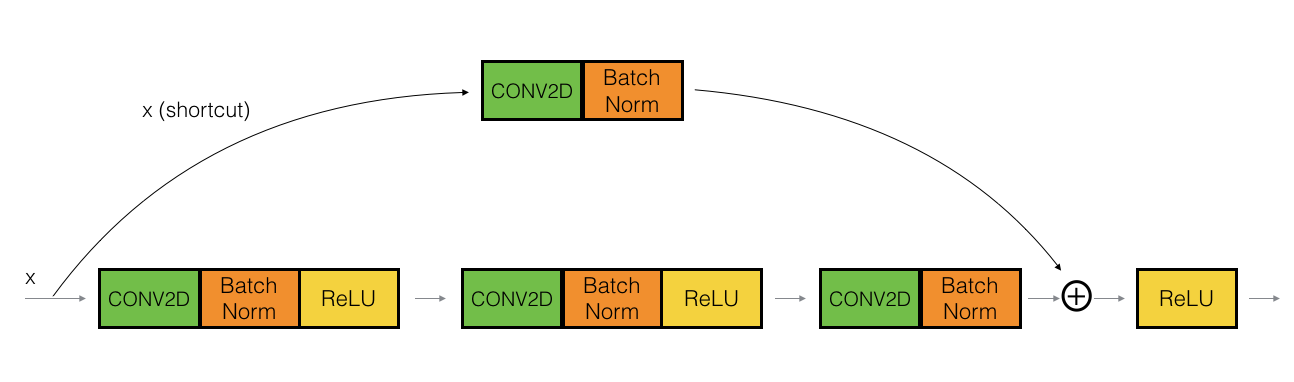

In [25]:
# Creating the Convolutional block

def convolutional_block(X, filters, s, initializer=glorot_uniform):
    
    F1, F2, F3 = filters
    
    X_shortcut = X

    # First component of the main path
    X = Conv2D(F1, (1, 1), padding='valid', strides=(s, s), kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of the main path
    X = Conv2D(F2, (3, 3), padding='same', strides=1, kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Third component of the main path
    X = Conv2D(F3, (1, 1), padding='valid', strides=1, kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization()(X)
    
    # The shortcut path
    X_shortcut = Conv2D(F3, (1, 1), padding='valid', strides=(s, s), kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    
    # Adding up main and shortcut values
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

<a name='3-3'></a>
### 3.3 -The ResNet50 model
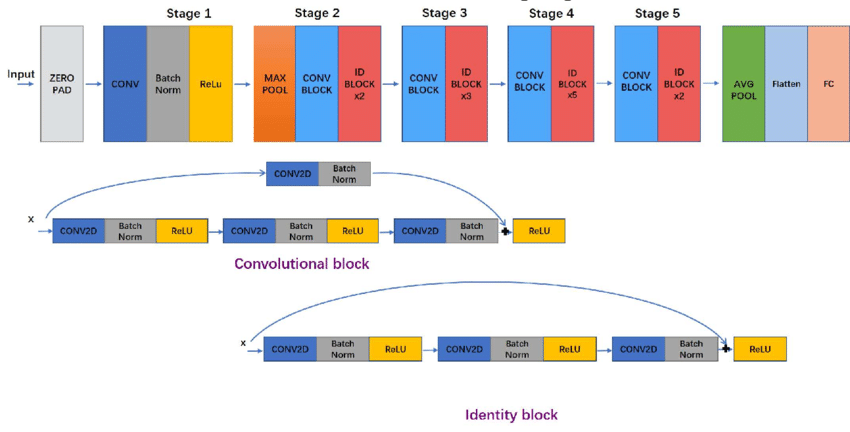

In [26]:
# Creating the Resnet50 model

def ResNet50(input_shape, classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides=2, kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D((3, 3), strides=2)(X)
    
    # Stage 2
    X = convolutional_block(X, [64, 64, 256], s = 1)
    X = identity_block(X, [64, 64, 256])
    X = identity_block(X, [64, 64, 256]) 
    
    # Stage 3
    X = convolutional_block(X, [128,128,512], s = 2)
    X = identity_block(X, [128,128,512]) 
    X = identity_block(X, [128,128,512]) 
    X = identity_block(X, [128,128,512]) 
    
    # Stage 4
    X = convolutional_block(X, [256, 256, 1024], s = 2)
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])    
    X = identity_block(X, [256, 256, 1024])    
    X = identity_block(X, [256, 256, 1024])    
    X = identity_block(X, [256, 256, 1024])
    
    # Stage 5
    X = convolutional_block(X, [512, 512, 2048], s = 2)
    X = identity_block(X, [512, 512, 2048])
    X = identity_block(X, [512, 512, 2048])    
    
    X = AveragePooling2D()(X)
    
    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs=X)
    
    return model

In [27]:
# Overview of the model
model = ResNet50((150, 150, 3), 6)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 156, 156, 3)  0          ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 75, 75, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                            

 activation_57 (Activation)     (None, 37, 37, 64)   0           ['batch_normalization_62[0][0]'] 
                                                                                                  
 conv2d_63 (Conv2D)             (None, 37, 37, 256)  16640       ['activation_57[0][0]']          
                                                                                                  
 batch_normalization_63 (BatchN  (None, 37, 37, 256)  1024       ['conv2d_63[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_18 (Add)                   (None, 37, 37, 256)  0           ['batch_normalization_63[0][0]', 
                                                                  'activation_55[0][0]']          
                                                                                                  
 activatio

                                                                                                  
 add_21 (Add)                   (None, 19, 19, 512)  0           ['batch_normalization_73[0][0]', 
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_67 (Activation)     (None, 19, 19, 512)  0           ['add_21[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 19, 19, 128)  65664       ['activation_67[0][0]']          
                                                                                                  
 batch_normalization_74 (BatchN  (None, 19, 19, 128)  512        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

                                )                                 'activation_73[0][0]']          
                                                                                                  
 activation_76 (Activation)     (None, 10, 10, 1024  0           ['add_24[0][0]']                 
                                )                                                                 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 10, 10, 256)  262400      ['activation_76[0][0]']          
                                                                                                  
 batch_normalization_84 (BatchN  (None, 10, 10, 256)  1024       ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_93 (Conv2D)             (None, 10, 10, 256)  262400      ['activation_85[0][0]']          
                                                                                                  
 batch_normalization_93 (BatchN  (None, 10, 10, 256)  1024       ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_86 (Activation)     (None, 10, 10, 256)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 10, 10, 256)  590080      ['activation_86[0][0]']          
                                                                                                  
 batch_normalization_94 (BatchN  (None, 10, 10, 256)  1024       ['conv2d_94[0][0]']              
 ormalizat

                                                                                                  
 activation_95 (Activation)     (None, 5, 5, 512)    0           ['batch_normalization_103[0][0]']
                                                                                                  
 conv2d_104 (Conv2D)            (None, 5, 5, 512)    2359808     ['activation_95[0][0]']          
                                                                                                  
 batch_normalization_104 (Batch  (None, 5, 5, 512)   2048        ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_96 (Activation)     (None, 5, 5, 512)    0           ['batch_normalization_104[0][0]']
                                                                                                  
 conv2d_10

<a name='4'></a>
## 4 - Training the model

In [ ]:
# Original model

# Compiling the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Defining step sizes for training and validation
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

# Training the model
history = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=10)

# Saving the model
model.save('Pretrained\ResNet50_model.h5')